In [19]:

# Modified script content with additional tuning, early stopping, and class distribution checks.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import joblib

In [20]:
#import the tensoflow libarys, these handel the the test/train split of the data, the model creation and the model comparison
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Concatenate, Multiply
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from tensorboard import notebook
import os
import datetime
import os
import datetime
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from tensorflow.keras.layers import Input, Dense, Dropout, Multiply
from tensorflow.keras import backend as K

In [21]:
# Load the data
df = pd.read_csv('C:/Users/honey/Documents/placment work/Electronical-AI-Device-Recogniser/khanya/data managment/datasets/acs-f2-dataset.csv')

In [22]:

# Drop the 'time' column as it's not relevant for prediction
df = df.drop('time', axis=1)


In [23]:
# Convert categorical labels to numeric
le = LabelEncoder()
df['equipment'] = le.fit_transform(df['equipment'])

# Split features and labels
X = df.drop('equipment', axis=1)
y = df['equipment']

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# One-hot encode the labels
y_resampled_onehot = to_categorical(y_resampled)

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled_onehot, test_size=0.2, random_state=42)

In [24]:
# Filepath for saving the best model
checkpoint_filepath = 'best_model.keras'

# Check if the best model exists
if os.path.exists(checkpoint_filepath):
    print("Loading the previously saved best model...")
    model = tf.keras.models.load_model(checkpoint_filepath)
else:
    print("No saved model found. Training a new model...")

    # Define the model architecture with weighted inputs and dropout
    input_layer = Input(shape=(X_train.shape[1],))

    # Define weights for each input feature
    weights = K.constant([[4.0, 2.0, 1.5, 1.0, 0.5, 0.2]])  # Adjust these weights as needed

    # Apply the weights to the input features
    weighted_inputs = Multiply()([input_layer, weights])

    # Add hidden layers
    x = Dense(64, activation='relu')(weighted_inputs)
    x = Dropout(0.5)(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(y_train.shape[1], activation='softmax')(x)

    # Create the model
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

# Compile the model with a lower learning rate for better generalization
initial_learning_rate = 0.0005
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True
)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# TensorBoard for logging
log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Ensure each model logs to its own separate folder
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Model checkpoint to save the best model
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, 
                                      monitor='val_loss', 
                                      save_best_only=True)

# Train the model with early stopping, TensorBoard callback, and model checkpoint
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test),
                    epochs=100, 
                    batch_size=128, 
                    callbacks=[early_stopping, tensorboard_callback, checkpoint_callback])


Loading the previously saved best model...
Epoch 1/100
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6510 - loss: 0.9782 - val_accuracy: 0.6923 - val_loss: 0.8891
Epoch 2/100
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6568 - loss: 0.9722 - val_accuracy: 0.6893 - val_loss: 0.8932
Epoch 3/100
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6511 - loss: 0.9789 - val_accuracy: 0.6967 - val_loss: 0.8734
Epoch 4/100
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6556 - loss: 0.9765 - val_accuracy: 0.7019 - val_loss: 0.8695
Epoch 5/100
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6545 - loss: 0.9715 - val_accuracy: 0.6949 - val_loss: 0.8772
Epoch 6/100
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6529 - loss: 0.9785 - val_accuracy: 0.6931 - val_loss: 0.8715
Epoch 7/100
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6551 - loss: 0.9759 - val_accuracy: 0.6984 - val_loss: 0.8709
Epoch 8/100
1011/1011 ━━━━━━━━━━━━━━━━━━

In [38]:
import os
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
print(logdir)


logs\20241010-144954


In [39]:
%reload_ext tensorboard

In [43]:
%tensorboard --logdir logs


Reusing TensorBoard on port 6013 (pid 16208), started 2:58:28 ago. (Use '!kill 16208' to kill it.)

1011/1011 ━━━━━━━━━━━━━━━━━━━━ 1s 645us/step


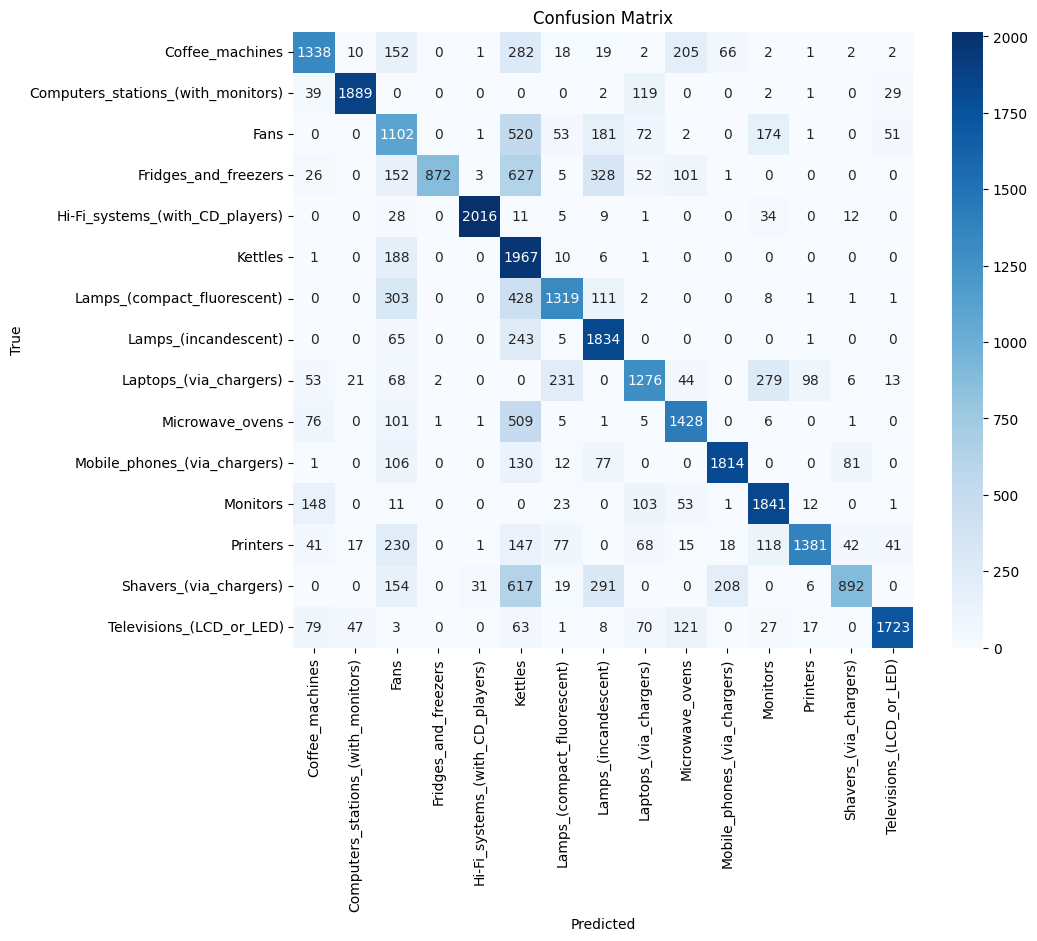

In [33]:
# Predict the labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [34]:
# # Save the trained model and the scaler for future use
# model.save('new-model1.0.4.keras')
# scaler = StandardScaler().fit(X_train)
# joblib.dump(scaler, 'new-scaler1.0.4.pkl')